In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt, spectrogram

In [3]:
def simulate_realistic_lfp_with_power_decay(fs, duration, ripple_freq=120, ripple_duration=0.1, ripple_amplitude=50, ripple_count=5, seed=42):
    """
    Simulate a realistic LFP signal with 1/f power decay, multiple frequency components, and ripples.

    Parameters:
    - fs: Sampling frequency in Hz.
    - duration: Duration of the signal in seconds.
    - ripple_freq: Frequency of the ripple events in Hz (default=100).
    - ripple_duration: Duration of each ripple event in seconds (default=0.1).
    - ripple_amplitude: Amplitude of the ripple events in µV (default=50).
    - ripple_count: Number of ripple events to embed (default=5).
    - seed: Seed for random number generation (default=42).

    Returns:
    - time: Time vector corresponding to the LFP signal.
    - lfp: Simulated raw LFP signal.
    """
    # np.random.seed(seed)
    np.random.seed()
    time = np.linspace(0, duration, int(duration * fs))

    # Generate 1/f noise (Brown noise)
    freqs = np.fft.rfftfreq(len(time), d=1/fs)
    amplitudes = 1 / (freqs[1:] ** 2)  # 1/f^2 for Brown noise
    amplitudes = np.concatenate(([0], amplitudes))  # Handle DC component
    phases = np.random.uniform(0, 2 * np.pi, len(amplitudes))
    brown_noise = np.fft.irfft(amplitudes * np.exp(1j * phases))
    brown_noise = brown_noise[:len(time)]  # Match length to time vector
    brown_noise = brown_noise / np.std(brown_noise) * 200  # Normalize to ~20 µV std

    # Add multiple frequency components with 1/f amplitude decay
    freq_bands = [1,3,4,7,10,20,30,35,40,80,110]  # Delta, theta, beta, gamma components
    freq_components = np.zeros_like(time)
    for freq in freq_bands:
        amplitude = 150 / np.sqrt(freq)  # Amplitude decreases with frequency
        freq_components += amplitude * np.sin(2 * np.pi * freq * time + np.random.uniform(0, 2 * np.pi))

    # Combine Brown noise with frequency components
    lfp = brown_noise + freq_components
    # lfp = lfp + 0.000001*np.random.normal(0.1, len(lfp))

    # Add synthetic ripples at random times
    ripple_times = np.random.uniform(2, duration - 2, ripple_count)  # Ripple events
    for ripple_time in ripple_times:
        start = int((ripple_time - ripple_duration / 2) * fs)
        end = int((ripple_time + ripple_duration / 2) * fs)
        lfp[start:end] += ripple_amplitude * np.sin(2 * np.pi * ripple_freq * time[start:end])

    return time, lfp

# Generate the realistic LFP with power decay
time, raw_lfp = simulate_realistic_lfp_with_power_decay(fs=1000, duration=10)

In [4]:
from scipy.ndimage import gaussian_filter
# Simulate raw LFP data
np.random.seed(42)
fs = 1000  # Sampling frequency (1 kHz)
duration = 10  # seconds

# Create a synthetic LFP signal with ripples (80-140 Hz)
ripple_freq = 120  # Hz
ripple_duration = 0.1  # seconds
ripple_amplitude = 50  # µV
# Generate the realistic LFP with power decay
time, raw_lfp = simulate_realistic_lfp_with_power_decay(fs=1000, duration=10)

# Add synthetic ripples at random times
ripple_times = np.random.uniform(2, duration - 2, 5)  # Ripple events
for ripple_time in ripple_times:
    start = int((ripple_time - ripple_duration / 2) * fs)
    end = int((ripple_time + ripple_duration / 2) * fs)
    raw_lfp[start:end] += ripple_amplitude * np.sin(2 * np.pi * ripple_freq * time[start:end])

# Step 1: Bandpass filter for ripple band (80-140 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

ripple_band_lfp = bandpass_filter(raw_lfp, 80, 140, fs)

# Step 2: Compute envelope using Hilbert transform
analytic_signal = hilbert(ripple_band_lfp)
envelope = np.abs(analytic_signal)
# envelope= analytic_signal

# Step 3: Detect ripples based on thresholds
threshold = 3 * np.std(envelope)  # Minimum threshold
ripple_events = envelope > threshold

# Step 4: Spectrogram
f, t, Sxx = spectrogram(raw_lfp, fs, nperseg=256, noverlap=200)
# Apply a Gaussian filter to smooth the spectrogram
Sxx_smooth = gaussian_filter(Sxx, sigma=3)  # Sigma determines the smoothing level
# Sxx_smooth = (Sxx_smooth - np.mean(Sxx_smooth)) / np.std(Sxx_smooth)
# Sxx_smooth = (Sxx_smooth - np.nanmean(Sxx_smooth))


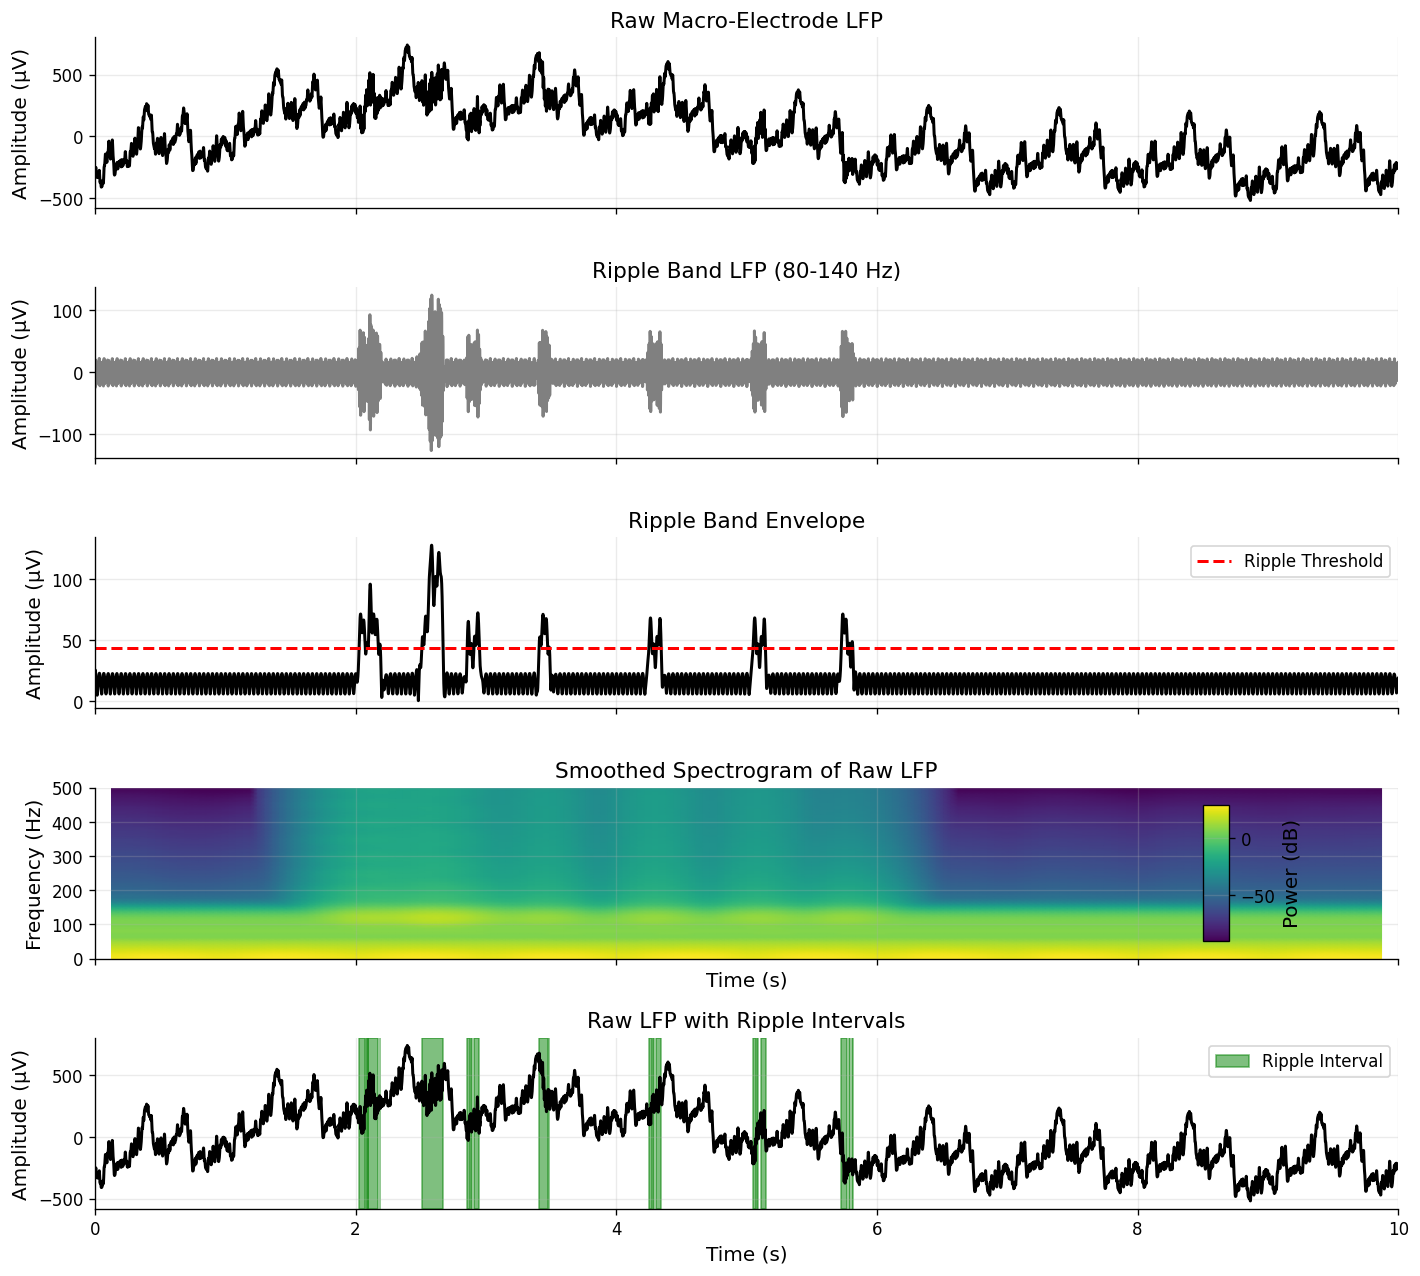

In [5]:
from scipy.ndimage import gaussian_filter
from matplotlib import ticker
import numpy as np
import matplotlib.pyplot as plt

# Detect ripple events based on the threshold
ripple_threshold = 3 * np.std(envelope)  # Set a ripple detection threshold
ripple_intervals = []
in_ripple = False
for i, val in enumerate(envelope):
    if val > ripple_threshold and not in_ripple:
        start = time[i]
        in_ripple = True
    elif val <= ripple_threshold and in_ripple:
        end = time[i]
        ripple_intervals.append((start, end))
        in_ripple = False

# Add one more subplot for the ripple intervals
fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

# Raw LFP
axs[0].plot(time, raw_lfp, color='black')
axs[0].set_title("Raw Macro-Electrode LFP")
axs[0].set_ylabel("Amplitude (µV)")

# Ripple band LFP
axs[1].plot(time, ripple_band_lfp, color='gray')
axs[1].set_title("Ripple Band LFP (80-140 Hz)")
axs[1].set_ylabel("Amplitude (µV)")

# Ripple band envelope
axs[2].plot(time, envelope, color='black')
axs[2].axhline(ripple_threshold, color='red', linestyle='--', label="Ripple Threshold")
axs[2].set_title("Ripple Band Envelope")
axs[2].set_ylabel("Amplitude (µV)")
axs[2].legend()

# Smoothed spectrogram
im = axs[3].pcolormesh(t, f, 10 * np.log10(Sxx_smooth), shading='gouraud', cmap='viridis')
axs[3].set_title("Smoothed Spectrogram of Raw LFP")
axs[3].set_ylabel("Frequency (Hz)")
axs[3].set_xlabel("Time (s)")

# Overlay the colorbar on the spectrogram plot
cbar_ax = axs[3].inset_axes([0.85, 0.1, 0.02, 0.8])  # [x, y, width, height] relative to the plot
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Power (dB)')

# Raw LFP with ripple intervals
axs[4].plot(time, raw_lfp, color='black')
for interval in ripple_intervals:
    axs[4].axvspan(interval[0], interval[1], color='green', alpha=0.5, label="Ripple Interval" if interval == ripple_intervals[0] else "")
axs[4].set_title("Raw LFP with Ripple Intervals")
axs[4].set_ylabel("Amplitude (µV)")
axs[4].set_xlabel("Time (s)")
axs[4].legend()

# Adjust x-axis limits
for ax in axs:
    ax.set_xlim([0, duration])

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout for the colorbar
plt.show()


In [6]:
# Erfan Updates for the algorithm:
'''
you need to contril for the integration of ripple power during the ripple interval.
It can be implemented as a secondary threshold candidate
'''

'\nyou need to contril for the integration of ripple power during the ripple interval.\nIt can be implemented as a secondary threshold candidate\n'

In [7]:
ripple_band_lfp = bandpass_filter(raw_lfp, 80, 140, fs)

In [8]:
#Eunji LFP
filename = "/Users/eunjikong/Dropbox/03_POSTDOC/00_LosonczyLab/01_Project/07_mini2p/ek193_rest_240607_123330.npy"
#filepath = '/Users/eunjikong/Data/LFP/ekez003/250818/eke003_spont_250818_175844.npy'
filename = '/Users/Erfan/Desktop/EK/SWR_Development/eke003_spont_250818_175844.npy'
filename = "/home/rudra/Documents/StocasticDiffEq_Simulation/notebooks/data/eke003_spont_250818_175844.npy"

channel_id = 1
raw_lfp = np.load(filename)[channel_id]
fs = 20000
time = np.arange(raw_lfp.shape[0]) / fs

ripple_band_lfp = bandpass_filter(raw_lfp, 80, 140, fs)

# Step 2: Compute envelope using Hilbert transform
analytic_signal = hilbert(ripple_band_lfp)
envelope = np.abs(analytic_signal)
# envelope= analytic_signal

# Step 3: Detect ripples based on thresholds
threshold = 3 * np.std(envelope)  # Minimum threshold
ripple_events = envelope > threshold

# Step 4: Spectrogram
f, t, Sxx = spectrogram(raw_lfp, fs, nperseg=256, noverlap=200)
# Apply a Gaussian filter to smooth the spectrogram
Sxx_smooth = gaussian_filter(Sxx, sigma=3)  # Sigma determines the smoothing level
# Sxx_smooth = (Sxx_smooth - np.mean(Sxx_smooth)) / np.std(Sxx_smooth)
# Sxx_smooth = (Sxx_smooth - np.nanmean(Sxx_smooth))


/tmp/ipykernel_2805320/2438672863.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[4].legend()


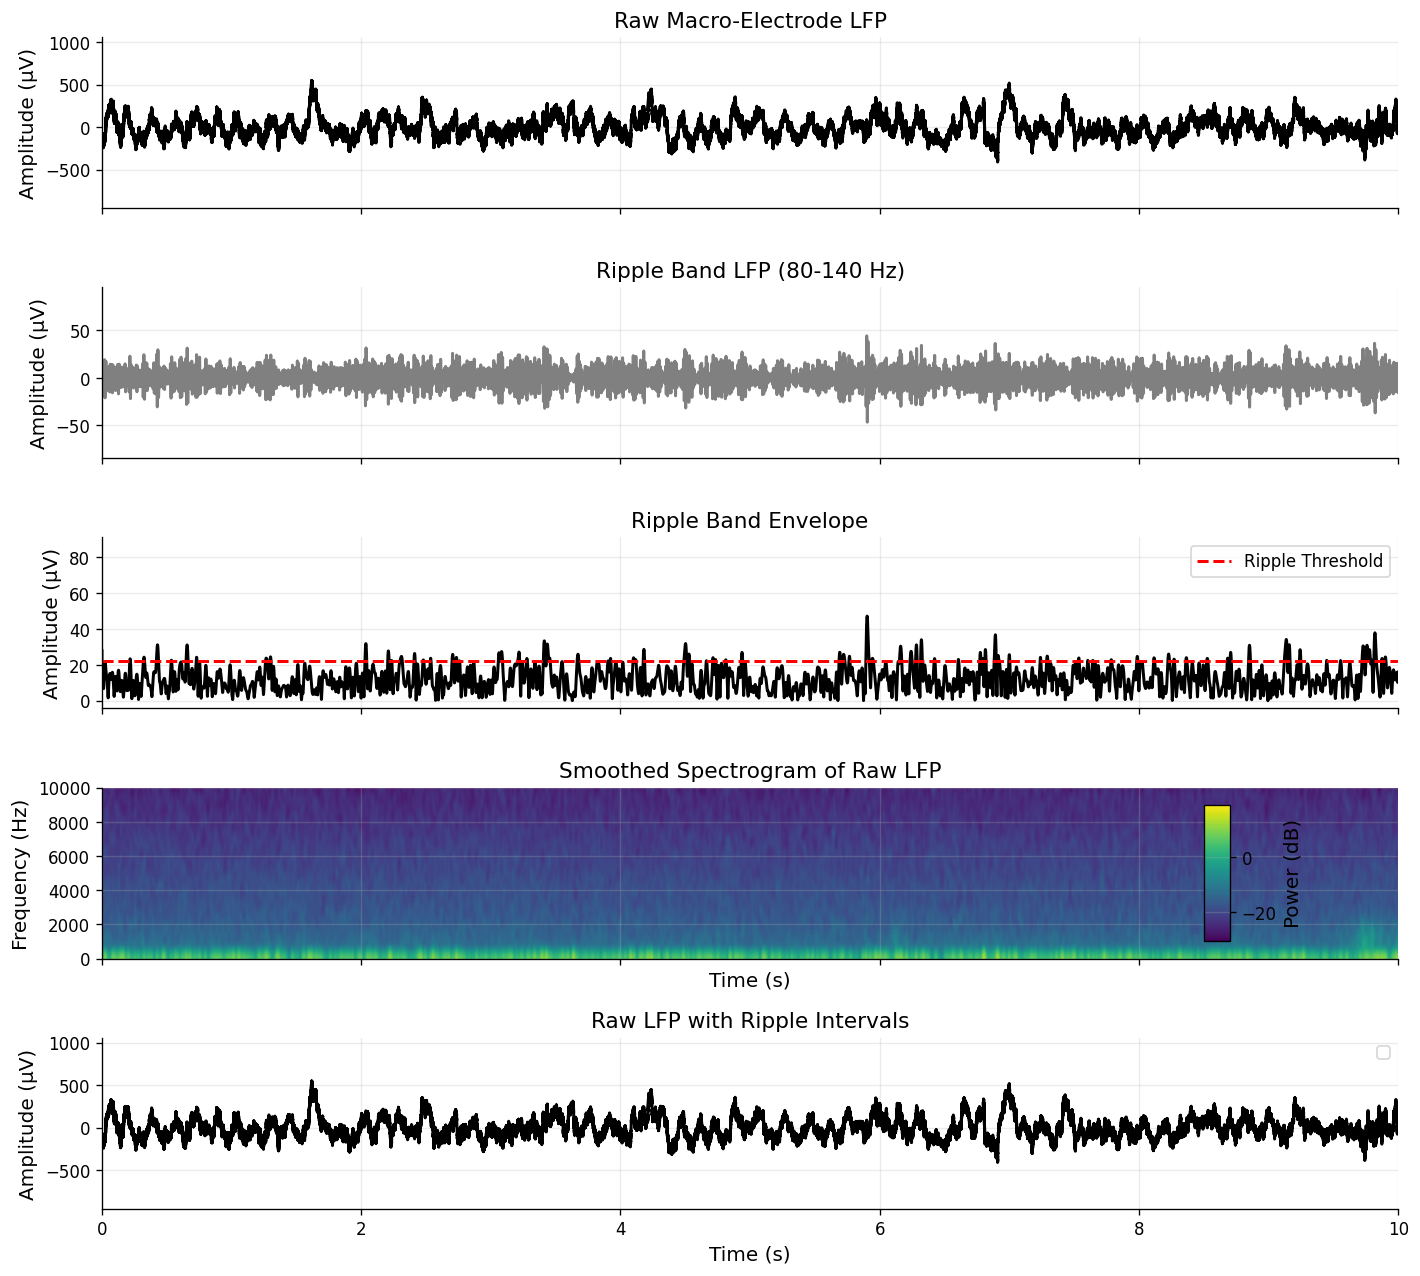

In [9]:
from scipy.ndimage import gaussian_filter
from matplotlib import ticker
import numpy as np
import matplotlib.pyplot as plt

# Detect ripple events based on the threshold
ripple_threshold = 3 * np.std(envelope)  # Set a ripple detection threshold
ripple_intervals = []
in_ripple = False
# for i, val in enumerate(envelope):
#     if val > ripple_threshold and not in_ripple:
#         start = time[i]
#         in_ripple = True
#     elif val <= ripple_threshold and in_ripple:
#         end = time[i]
#         ripple_intervals.append((start, end))
#         in_ripple = False

# Add one more subplot for the ripple intervals
fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

# Raw LFP
axs[0].plot(time, raw_lfp, color='black')
axs[0].set_title("Raw Macro-Electrode LFP")
axs[0].set_ylabel("Amplitude (µV)")

# Ripple band LFP
axs[1].plot(time, ripple_band_lfp, color='gray')
axs[1].set_title("Ripple Band LFP (80-140 Hz)")
axs[1].set_ylabel("Amplitude (µV)")

# Ripple band envelope
axs[2].plot(time, envelope, color='black')
axs[2].axhline(ripple_threshold, color='red', linestyle='--', label="Ripple Threshold")
axs[2].set_title("Ripple Band Envelope")
axs[2].set_ylabel("Amplitude (µV)")
axs[2].legend()

# Smoothed spectrogram
im = axs[3].pcolormesh(t, f, 10 * np.log10(Sxx_smooth), shading='gouraud', cmap='viridis')
axs[3].set_title("Smoothed Spectrogram of Raw LFP")
axs[3].set_ylabel("Frequency (Hz)")
axs[3].set_xlabel("Time (s)")

# Overlay the colorbar on the spectrogram plot
cbar_ax = axs[3].inset_axes([0.85, 0.1, 0.02, 0.8])  # [x, y, width, height] relative to the plot
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Power (dB)')

# Raw LFP with ripple intervals
axs[4].plot(time, raw_lfp, color='black')
for interval in ripple_intervals:
    axs[4].axvspan(interval[0], interval[1], color='green', alpha=0.5, label="Ripple Interval" if interval == ripple_intervals[0] else "")
axs[4].set_title("Raw LFP with Ripple Intervals")
axs[4].set_ylabel("Amplitude (µV)")
axs[4].set_xlabel("Time (s)")
axs[4].legend()

# Adjust x-axis limits
for ax in axs:
    ax.set_xlim([0, duration])

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout for the colorbar
plt.show()

In [10]:
fs
time

array([0.0000000e+00, 5.0000000e-05, 1.0000000e-04, ..., 5.4208785e+02,
       5.4208790e+02, 5.4208795e+02], shape=(10841760,))

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import mne

# ---- pick the only channel ----
LFP = np.asarray(raw_lfp)
if LFP.ndim == 2:        # (T, C)
    x = LFP[:, 0]
else:                    # (T,)
    x = LFP.ravel()

T = len(x)
time = np.arange(T) / fs

# ---- 1) Power spectrum (Welch via MNE) ----
psd, freqs = mne.time_frequency.psd_array_welch(
    x[None, :],            # shape (1, n_times)
    sfreq=fs,
    fmin=0.5, fmax=200.0,  # LFP range
    n_fft=4096,
    n_overlap=2048,
    average='mean',
    verbose=False
)
psd = psd[0]              # back to (n_freq,)





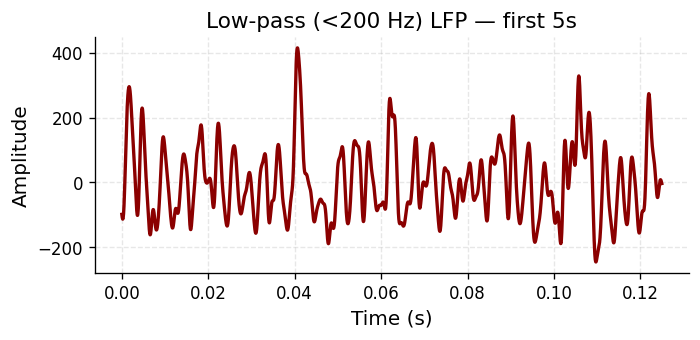

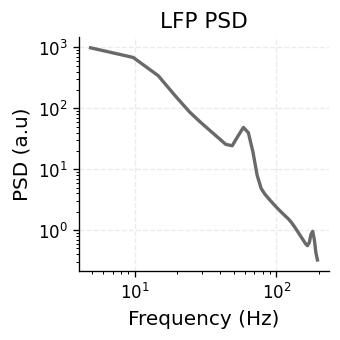

In [12]:
# ==== LFP → xs adaptor (run BEFORE AR block) ====
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import mne


# ---- 2) Low-pass <200 Hz ----
b_lp, a_lp = signal.butter(4, 10/(fs/2), btype='low')
x_lp = signal.filtfilt(b_lp, a_lp, x, method='gust')

# ---- 2) Band-pass (e.g., 4–12 Hz) and plot a short snippet ----
# low, high = 1.0, 65.0               # Hz (set the band you want)
low, high = 1.0, 20.0               # Hz (set the band you want)
wn = [low/(fs/2), high/(fs/2)]      # normalized cutoffs

# (robust) SOS form:
sos = signal.butter(4, wn, btype='bandpass', output='sos')
x_lp = signal.sosfiltfilt(sos, x)
xs = x_lp

# ---- 3) Z-score (AR prefers stationary scale) ----
# xs = ((x_lp - np.mean(x_lp)) / (np.std(x_lp) + 1e-12)).astype(float)

# ---- 4) Optional: downsample for modest AR orders ----
target_Fs = 500
if fs > target_Fs:
    r = int(np.floor(fs / target_Fs))
    xs = signal.decimate(xs, r, ftype='iir', zero_phase=True).astype(float)
    fs = fs / r  # update sampling rate for consistency




# choose a snippet to display (e.g., first 5 s)
snippet_sec = 5
N = int(snippet_sec * fs)
t_snip = time[:N]
x_snip = xs[:N]

plt.figure(figsize=(6,3))
plt.plot(t_snip, x_snip, lw=2.0, color='darkred')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Low-pass (<200 Hz) LFP — first {snippet_sec:g}s")
plt.grid(True, ls='--', alpha=0.3)
plt.box('off')

plt.tight_layout()
plt.show()





from scipy.ndimage import gaussian_filter1d

# smooth each PSD along frequency axis
psd = gaussian_filter1d(psd, sigma=1)

plt.figure(figsize=(3,3))
plt.loglog(freqs, psd, 'dimgray', lw=2, label="z")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (a.u)")
plt.title("LFP PSD")
plt.grid(True, ls="--", alpha=0.25)
# plt.xlim(0,80)
# plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# import mne

# # xs = raw_lfp[t:2*t]
# xs = raw_lfp[:t]
# xs = ((xs - np.mean(xs)) / (np.std(xs) + 1e-12)).astype(float)

# fs = fs
# burn = 2000  # drop transient
# data = np.vstack(xs[burn:])  # shape = (3, n_times)

# # --- compute PSD for all three channels ---
# psds, freqs = mne.time_frequency.psd_array_welch(
#     data,
#     sfreq=fs,
#     fmin=0.1, fmax=10,
#     n_fft=4096,
#     n_overlap=2048,
#     average='mean'
# )


# from scipy.ndimage import gaussian_filter1d

# # smooth each PSD along frequency axis
# Pxx_smooth = gaussian_filter1d(psds[0], sigma=2)
# Pyy_smooth = gaussian_filter1d(psds[1], sigma=2)
# Pzz_smooth = gaussian_filter1d(psds[2], sigma=2)

# plt.figure(figsize=(3,3))
# plt.loglog(freqs, Pxx_smooth, 'k', lw=2, label="x")
# plt.loglog(freqs, Pyy_smooth, 'darkred', lw=2, label="y")
# plt.loglog(freqs, Pzz_smooth, 'dimgray', lw=2, label="z")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("PSD (smoothed)")
# plt.title("Lorenz PSD (Gaussian-smoothed)")
# plt.grid(True, ls="--", alpha=0.25)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [14]:
# np.shape(raw_lfp)
# import numpy as np
# from scipy import signal

# t = 2000




# xs = raw_lfp[t+2000:3*t]
# # xs = raw_lfp[1000:t]
# xs = ((xs - np.mean(xs)) / (np.std(xs) + 1e-12)).astype(float)



# # ---- 2) Band-pass (e.g., 4–12 Hz) and plot a short snippet ----
# low, high = 1.1, 50.0               # Hz (set the band you want)
# wn = [low/(fs/2), high/(fs/2)]      # normalized cutoffs
# # (robust) SOS form:
# sos = signal.butter(4, wn, btype='bandpass', output='sos')
# xs = signal.sosfiltfilt(sos, xs)


# from scipy.signal import butter, filtfilt


# def downsample_signal(x, fs, k, cutoff=None):
#     """
#     x : array
#         Input signal
#     fs : float
#         Original sampling rate
#     k : int
#         Downsampling factor
#     cutoff : float, optional
#         Low-pass cutoff before downsampling (default = 0.8 * fs/(2*k))
#     """
#     if cutoff is None:
#         cutoff = 0.8 * (fs / (2*k))  # just below new Nyquist
#     b, a = butter(4, cutoff / (fs/2), btype='low')
#     x_filt = filtfilt(b, a, x)
#     return x_filt[::k], fs / k

# # Example
# K=1
# xs, fs_down = downsample_signal(xs, fs, k=K)




# plt.plot(xs, color='black')

In [15]:
xs = x_snip

Best p by TEST MSE: p=3, MSE=0.075200
Best p by BIC (training fit): p=3


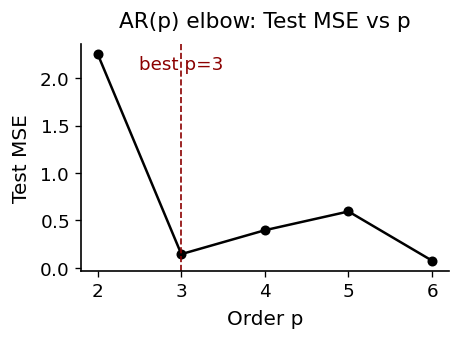

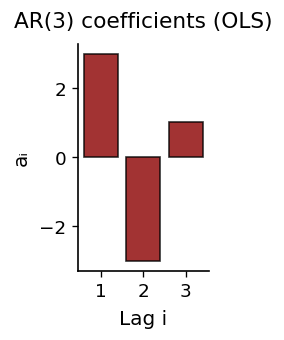

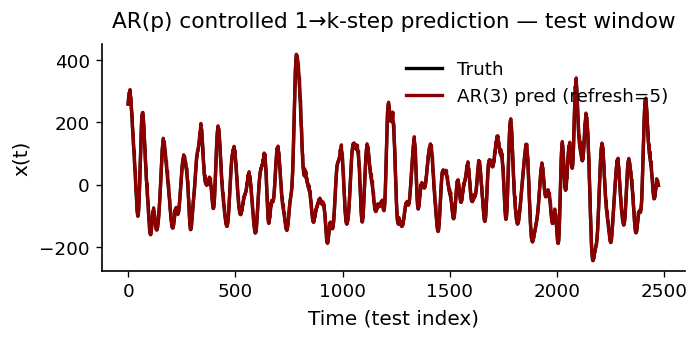

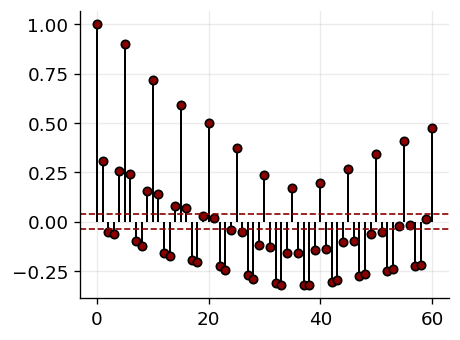

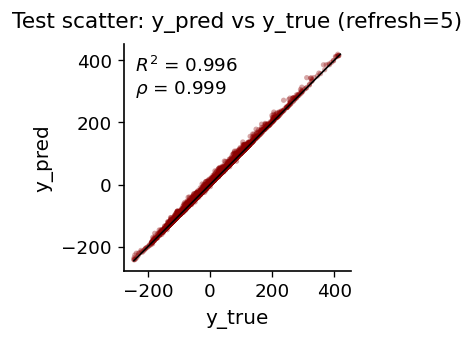

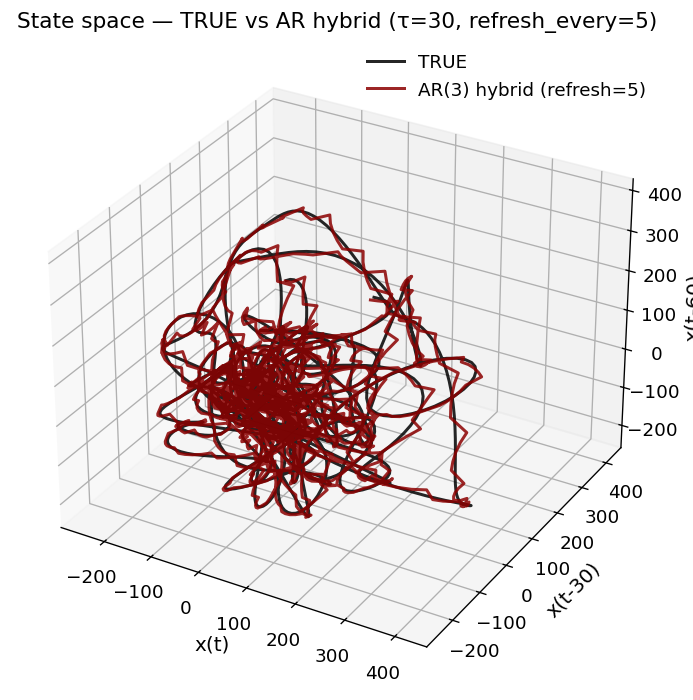

In [16]:
# Publication-style plotting for your AR(p) baseline + y_pred vs y_true scatter.
# (Matplotlib only, one chart per figure, no explicit colors.)

import numpy as np
import matplotlib.pyplot as plt

# ------------ Global plot style (no explicit colors) ------------
def set_pub_style():
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.8,
        "lines.markersize": 5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
    })

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if add_legend:
        ax.legend(frameon=False)
    ax.margins(x=0.02)

set_pub_style()

# # ---------- Data (Lorenz) ----------
# def lorenz(T_steps=30000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0,1.0,1.0)):
#     x, y, z = x0
#     xs, ys, zs = [], [], []
#     for _ in range(T_steps):
#         def f(x,y,z):
#             dx = sigma*(y-x)
#             dy = x*(rho - z) - y
#             dz = x*y - beta*z
#             return dx, dy, dz
#         k1 = f(x,y,z)
#         k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
#         k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
#         k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
#         x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
#         y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
#         z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
#         xs.append(x); ys.append(y); zs.append(z)
#     return np.array(xs), np.array(ys), np.array(zs)

# xs, ys, zs = lorenz()

# ---------- AR helpers ----------
def lag_matrix(x, p):
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def ols_with_intercept(X, y):
    D = np.column_stack([np.ones(len(X)), X])
    w = np.linalg.lstsq(D, y, rcond=None)[0]
    return w  # [c, a1..ap]

def predict_from_params(X, w):
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    r = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp))
    return mse, mae, r

def acf(sig, nlags=60):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac0 = ac[0] if ac[0] != 0 else 1.0
    ac = ac / ac0
    return ac[:nlags+1]

def aic_bic(y, yhat, k):
    n = len(y)
    rss = np.sum((y - yhat)**2)
    sigma2 = rss / max(n, 1)
    aic = n*np.log(sigma2 + 1e-12) + 2*k
    bic = n*np.log(sigma2 + 1e-12) + k*np.log(max(n, 2))
    return aic, bic

# ---------- Sweep p and pick best ----------
p_list = list(range(2, 7))
mse_te_list, aic_list, bic_list = [], [], []
params_by_p = {}
splits = {}

for p in p_list:
    X, y = lag_matrix(xs, p)
    N = len(y)
    ntr = int(0.01 * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]
    w = ols_with_intercept(X_tr, y_tr)
    yhat_tr = predict_from_params(X_tr, w)
    yhat_te = predict_from_params(X_te, w)
    mse_te, _, _ = metrics(y_te, yhat_te)
    aic, bic = aic_bic(y_tr, yhat_tr, k=p+1)
    mse_te_list.append(mse_te); aic_list.append(aic); bic_list.append(bic)
    params_by_p[p] = w
    splits[p] = (ntr, y, yhat_tr, yhat_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]

best_p_by_mse = 3
best_p_by_bic = 3

print(f"Best p by TEST MSE: p={best_p_by_mse}, MSE={min(mse_te_list):.6f}")
print(f"Best p by BIC (training fit): p={best_p_by_bic}")

# ====== NEW: controllable-step rollout (works everywhere below) ======
# Set how often to refresh with ground truth:
#   1 -> classic 1-step (teacher forcing every step)
#   big (>= test length) -> approx free-run
#   k -> run k-1 steps open-loop, then refresh once
REFRESH_EVERY = 5 #prediction step

def hybrid_ar(series, w, p, start_idx, n_steps, refresh_every=1):
    preds = []
    hist = series[start_idx - p : start_idx].tolist()  # seed with TRUE history
    for t in range(n_steps):
        if (t % max(int(refresh_every), 1)) == 0:
            abs_idx = start_idx + t
            hist = series[abs_idx - p : abs_idx].tolist()
        # match lag_matrix's most-recent-first order
        xhat = w[0] + np.dot(w[1:], list(reversed(hist)))
        preds.append(xhat)
        hist.pop(0); hist.append(xhat)
    return np.array(preds)

# Prepare indices for the chosen p
p_use = best_p_by_bic
w = params_by_p[p_use]
X, y = lag_matrix(xs, p_use)
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
N_te = len(y) - ntr
t0   = p_use + ntr            # absolute index where test begins in xs
true_test = xs[t0 : t0 + N_te]

# Controlled predictions (replaces pure 1-step in figs 3–5)
yhat_ctrl = hybrid_ar(xs, w, p_use, start_idx=t0, n_steps=N_te, refresh_every=REFRESH_EVERY)

# ---------- (re-imports from your original snippet) ----------
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# ---------- Global style ----------
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

color_main = "black"
color_alt = "darkred"

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    """Unified styling for axes."""
    if title: ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    ax.grid(alpha=0.0, linestyle="--", linewidth=0.7)
    if add_legend: 
        ax.legend(frameon=False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.0)

# ---------- 1) Elbow (MSE vs p) ----------
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(p_list, mse_te_list, marker='o', color=color_main, lw=1.5, ms=5)
ax.axvline(best_p_by_mse, linestyle='--', color=color_alt, linewidth=1)
ax.text(best_p_by_mse, ax.get_ylim()[1]*0.95, f"best p={best_p_by_mse}",
        ha='center', va='top', color=color_alt, fontsize=11)

sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(sf)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.get_offset_text().set_size(10)
prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
plt.tight_layout(); plt.show()

# ---------- 2) Coefficients (bar) for chosen p ----------
fig, ax = plt.subplots(figsize=(2,3))
bars = ax.bar(np.arange(1, p_use+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
prettify(ax, title=f"AR({p_use}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
plt.tight_layout(); plt.show()

# ---------- 3) Test-window prediction (now uses controllable rollout) ----------
fig, ax = plt.subplots(figsize=(6,3))
win = slice(ntr, len(y))  # full test window
ax.plot(y[win] + 1, color=color_main, lw=2, label="Truth")
ax.plot(yhat_ctrl[:win.stop-win.start], color=color_alt, lw=2,
        label=f"AR({p_use}) pred (refresh={REFRESH_EVERY})")
prettify(ax, title="AR(p) controlled 1→k-step prediction — test window", 
         xlabel="Time (test index)", ylabel="x(t)", add_legend=True)
plt.tight_layout(); plt.show()

# ---------- 4) Residual ACF (test) with bounds — uses controllable rollout ----------
resid_te = y[ntr:] - yhat_ctrl
acf_vals = acf(resid_te, nlags=60)
N_te = len(resid_te)
bound = 1.96 / np.sqrt(max(N_te,1))

fig, ax = plt.subplots(figsize=(4,3))
markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")
plt.setp(stemlines, color=color_main, linewidth=1.2)
plt.setp(markerline, marker='o', markersize=5,
         markeredgecolor=color_main, markerfacecolor=color_alt)
ax.axhline(bound, linestyle='--', color=color_alt, linewidth=1)
ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)
plt.tight_layout(); plt.show()

# ---------- 5) y_pred vs y_true (test) — uses controllable rollout ----------
y_true = y[ntr:]
y_pred = yhat_ctrl
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
vmin = min(np.min(y_true), np.min(y_pred))
vmax = max(np.max(y_true), np.max(y_pred))
ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)
yt = y_true - np.mean(y_true)
yp = y_pred - np.mean(y_pred)
corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res / (ss_tot + 1e-12)
ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
ax.set_aspect('equal', adjustable='box')
prettify(ax, title=f"Test scatter: y_pred vs y_true (refresh={REFRESH_EVERY})",
         xlabel="y_true", ylabel="y_pred")
plt.tight_layout(); plt.show()

# ---------- 6) State space — TRUE vs controlled AR (variance-matched) ----------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def embed3(s, tau):
    return np.column_stack([s[2*tau:], s[tau:-tau], s[:-2*tau]])

tau = 30
# variance-match for fair geometric overlay
hy = yhat_ctrl - np.mean(yhat_ctrl)
hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

X3_true = embed3(true_test, tau)
X3_hyb  = embed3(hy,        tau)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X3_true[:,0], X3_true[:,1], X3_true[:,2], label="TRUE",color="black", alpha=0.85)
ax.plot(X3_hyb[:,0],  X3_hyb[:,1],  X3_hyb[:,2],
        label=f"AR({p_use}) hybrid (refresh={REFRESH_EVERY})",color="darkred", alpha=0.85)
ax.set_title(f"State space — TRUE vs AR hybrid (τ={tau}, refresh_every={REFRESH_EVERY})")
ax.set_xlabel("x(t)"); ax.set_ylabel(f"x(t-{tau})"); ax.set_zlabel(f"x(t-{2*tau})")
ax.legend(frameon=False); plt.tight_layout(); plt.show()


In [17]:
import numpy as np
from scipy import signal
from scipy.signal import hilbert

def envelope_normalize(x, fs, fband=(15, 30), env_lp_hz=5.0, eps=1e-6):
    # 1) band-pass
    b, a = signal.butter(4, np.array(fband)/(fs/2), btype='bandpass')
    x_bp = signal.filtfilt(b, a, x)

    # 2–3) envelope via Hilbert, then smooth (optional)
    z = hilbert(x_bp)
    A = np.abs(z)
    if env_lp_hz is not None:
        b_lp, a_lp = signal.butter(2, env_lp_hz/(fs/2), btype='low')
        A = signal.filtfilt(b_lp, a_lp, A)

    # 4) divide out envelope
    x_flat = x_bp / (A + eps)

    # Optional: keep average scale
    x_flat *= np.median(A)
    return x_flat, x_bp, A


In [18]:
xs

# ---- Apply normalization ----
xs, x_bp, A_est = envelope_normalize(xs, fs, fband=(1, 80), env_lp_hz=3.0)



Best p by TEST MSE: p=3, MSE=0.000002
Best p by BIC (training fit): p=3


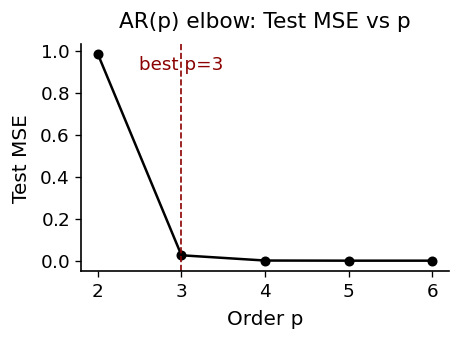

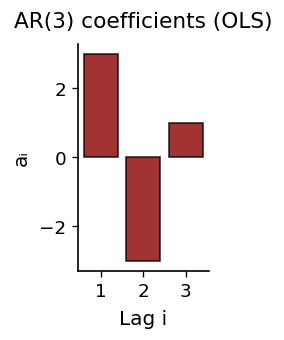

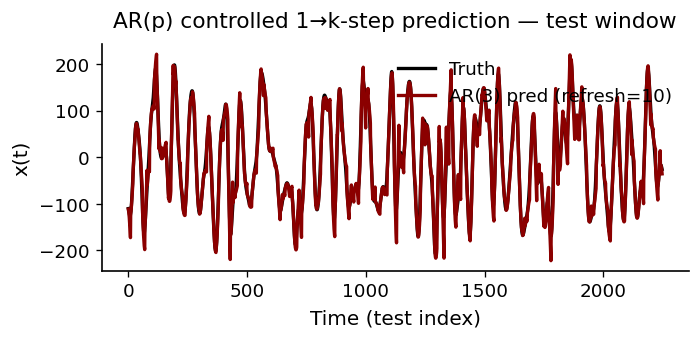

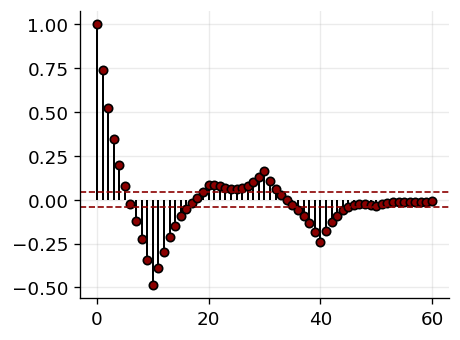

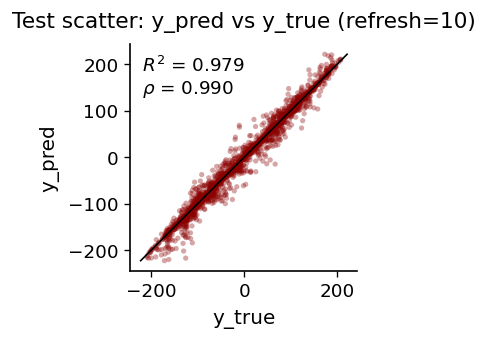

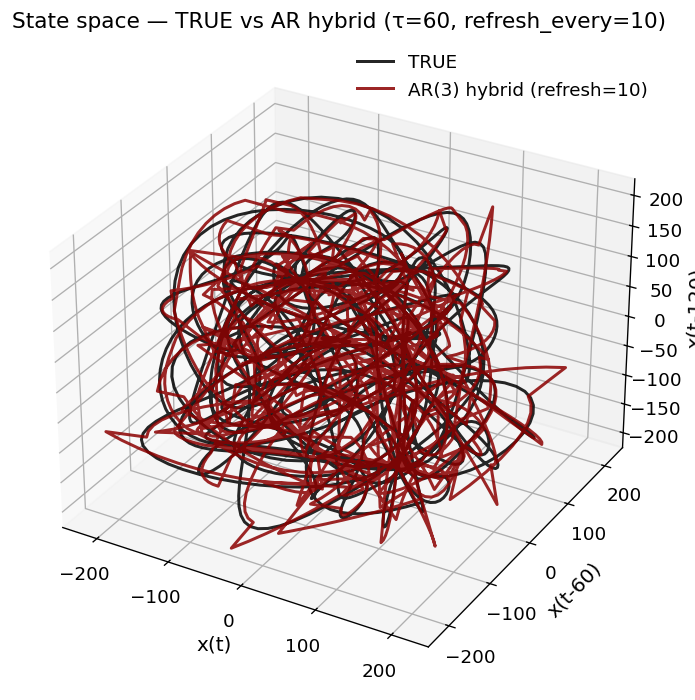

In [20]:
# Publication-style plotting for your AR(p) baseline + y_pred vs y_true scatter.
# (Matplotlib only, one chart per figure, no explicit colors.)

import numpy as np
import matplotlib.pyplot as plt

# ------------ Global plot style (no explicit colors) ------------
def set_pub_style():
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.8,
        "lines.markersize": 5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
    })

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if add_legend:
        ax.legend(frameon=False)
    ax.margins(x=0.02)

set_pub_style()

# # ---------- Data (Lorenz) ----------
# def lorenz(T_steps=30000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0,1.0,1.0)):
#     x, y, z = x0
#     xs, ys, zs = [], [], []
#     for _ in range(T_steps):
#         def f(x,y,z):
#             dx = sigma*(y-x)
#             dy = x*(rho - z) - y
#             dz = x*y - beta*z
#             return dx, dy, dz
#         k1 = f(x,y,z)
#         k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
#         k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
#         k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
#         x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
#         y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
#         z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
#         xs.append(x); ys.append(y); zs.append(z)
#     return np.array(xs), np.array(ys), np.array(zs)

# xs, ys, zs = lorenz()

# ---------- AR helpers ----------
def lag_matrix(x, p):
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def ols_with_intercept(X, y):
    D = np.column_stack([np.ones(len(X)), X])
    w = np.linalg.lstsq(D, y, rcond=None)[0]
    return w  # [c, a1..ap]

def predict_from_params(X, w):
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    r = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp))
    return mse, mae, r

def acf(sig, nlags=60):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac0 = ac[0] if ac[0] != 0 else 1.0
    ac = ac / ac0
    return ac[:nlags+1]

def aic_bic(y, yhat, k):
    n = len(y)
    rss = np.sum((y - yhat)**2)
    sigma2 = rss / max(n, 1)
    aic = n*np.log(sigma2 + 1e-12) + 2*k
    bic = n*np.log(sigma2 + 1e-12) + k*np.log(max(n, 2))
    return aic, bic

# ---------- Sweep p and pick best ----------
p_list = list(range(2, 7))
mse_te_list, aic_list, bic_list = [], [], []
params_by_p = {}
splits = {}

for p in p_list:
    X, y = lag_matrix(xs, p)
    N = len(y)
    ntr = int(0.1 * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]
    w = ols_with_intercept(X_tr, y_tr)
    yhat_tr = predict_from_params(X_tr, w)
    yhat_te = predict_from_params(X_te, w)
    mse_te, _, _ = metrics(y_te, yhat_te)
    aic, bic = aic_bic(y_tr, yhat_tr, k=p+1)
    mse_te_list.append(mse_te); aic_list.append(aic); bic_list.append(bic)
    params_by_p[p] = w
    splits[p] = (ntr, y, yhat_tr, yhat_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]

best_p_by_mse = 3
best_p_by_bic = 3

print(f"Best p by TEST MSE: p={best_p_by_mse}, MSE={min(mse_te_list):.6f}")
print(f"Best p by BIC (training fit): p={best_p_by_bic}")

# ====== NEW: controllable-step rollout (works everywhere below) ======
# Set how often to refresh with ground truth:
#   1 -> classic 1-step (teacher forcing every step)
#   big (>= test length) -> approx free-run
#   k -> run k-1 steps open-loop, then refresh once
REFRESH_EVERY = 10 #prediction step

def hybrid_ar(series, w, p, start_idx, n_steps, refresh_every=1):
    preds = []
    hist = series[start_idx - p : start_idx].tolist()  # seed with TRUE history
    for t in range(n_steps):
        if (t % max(int(refresh_every), 1)) == 0:
            abs_idx = start_idx + t
            hist = series[abs_idx - p : abs_idx].tolist()
        # match lag_matrix's most-recent-first order
        xhat = w[0] + np.dot(w[1:], list(reversed(hist)))
        preds.append(xhat)
        hist.pop(0); hist.append(xhat)
    return np.array(preds)

# Prepare indices for the chosen p
p_use = best_p_by_bic
w = params_by_p[p_use]
X, y = lag_matrix(xs, p_use)
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
N_te = len(y) - ntr
t0   = p_use + ntr            # absolute index where test begins in xs
true_test = xs[t0 : t0 + N_te]

# Controlled predictions (replaces pure 1-step in figs 3–5)
yhat_ctrl = hybrid_ar(xs, w, p_use, start_idx=t0, n_steps=N_te, refresh_every=REFRESH_EVERY)

# ---------- (re-imports from your original snippet) ----------
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# ---------- Global style ----------
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

color_main = "black"
color_alt = "darkred"

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    """Unified styling for axes."""
    if title: ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    ax.grid(alpha=0.0, linestyle="--", linewidth=0.7)
    if add_legend: 
        ax.legend(frameon=False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.0)

# ---------- 1) Elbow (MSE vs p) ----------
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(p_list, mse_te_list, marker='o', color=color_main, lw=1.5, ms=5)
ax.axvline(best_p_by_mse, linestyle='--', color=color_alt, linewidth=1)
ax.text(best_p_by_mse, ax.get_ylim()[1]*0.95, f"best p={best_p_by_mse}",
        ha='center', va='top', color=color_alt, fontsize=11)

sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(sf)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.get_offset_text().set_size(10)
prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
plt.tight_layout(); plt.show()

# ---------- 2) Coefficients (bar) for chosen p ----------
fig, ax = plt.subplots(figsize=(2,3))
bars = ax.bar(np.arange(1, p_use+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
prettify(ax, title=f"AR({p_use}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
plt.tight_layout(); plt.show()

# ---------- 3) Test-window prediction (now uses controllable rollout) ----------
fig, ax = plt.subplots(figsize=(6,3))
win = slice(ntr, len(y))  # full test window
ax.plot(y[win] + 1, color=color_main, lw=2, label="Truth")
ax.plot(yhat_ctrl[:win.stop-win.start], color=color_alt, lw=2,
        label=f"AR({p_use}) pred (refresh={REFRESH_EVERY})")
prettify(ax, title="AR(p) controlled 1→k-step prediction — test window", 
         xlabel="Time (test index)", ylabel="x(t)", add_legend=True)
plt.tight_layout(); plt.show()

# ---------- 4) Residual ACF (test) with bounds — uses controllable rollout ----------
resid_te = y[ntr:] - yhat_ctrl
acf_vals = acf(resid_te, nlags=60)
N_te = len(resid_te)
bound = 1.96 / np.sqrt(max(N_te,1))

fig, ax = plt.subplots(figsize=(4,3))
markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")
plt.setp(stemlines, color=color_main, linewidth=1.2)
plt.setp(markerline, marker='o', markersize=5,
         markeredgecolor=color_main, markerfacecolor=color_alt)
ax.axhline(bound, linestyle='--', color=color_alt, linewidth=1)
ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)
plt.tight_layout(); plt.show()

# ---------- 5) y_pred vs y_true (test) — uses controllable rollout ----------
y_true = y[ntr:]
y_pred = yhat_ctrl
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
vmin = min(np.min(y_true), np.min(y_pred))
vmax = max(np.max(y_true), np.max(y_pred))
ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)
yt = y_true - np.mean(y_true)
yp = y_pred - np.mean(y_pred)
corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res / (ss_tot + 1e-12)
ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
ax.set_aspect('equal', adjustable='box')
prettify(ax, title=f"Test scatter: y_pred vs y_true (refresh={REFRESH_EVERY})",
         xlabel="y_true", ylabel="y_pred")
plt.tight_layout(); plt.show()

# ---------- 6) State space — TRUE vs controlled AR (variance-matched) ----------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def embed3(s, tau):
    return np.column_stack([s[2*tau:], s[tau:-tau], s[:-2*tau]])

# tau = 5
tau =60

# variance-match for fair geometric overlay
hy = yhat_ctrl - np.mean(yhat_ctrl)
hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

X3_true = embed3(true_test, tau)
X3_hyb  = embed3(hy,        tau)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X3_true[:,0], X3_true[:,1], X3_true[:,2], label="TRUE",color="black", alpha=0.85)
ax.plot(X3_hyb[:,0],  X3_hyb[:,1],  X3_hyb[:,2],
        label=f"AR({p_use}) hybrid (refresh={REFRESH_EVERY})",color="darkred", alpha=0.85)
ax.set_title(f"State space — TRUE vs AR hybrid (τ={tau}, refresh_every={REFRESH_EVERY})")
ax.set_xlabel("x(t)"); ax.set_ylabel(f"x(t-{tau})"); ax.set_zlabel(f"x(t-{2*tau})")
ax.legend(frameon=False); plt.tight_layout(); plt.show()
